In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [9]:
# Import essential libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load datasets
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
gender_sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# Store PassengerId for submission
test_ids = test['PassengerId'].copy()

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("\nFirst few rows:")
print(train.head())
print("\nData info:")
print(train.info())
print("\nMissing values:")
print(train.isnull().sum())

Train shape: (891, 12)
Test shape: (418, 11)

First few rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123     

Survival Rate: 0.3838383838383838

Survival by Gender:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Survival by Class:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


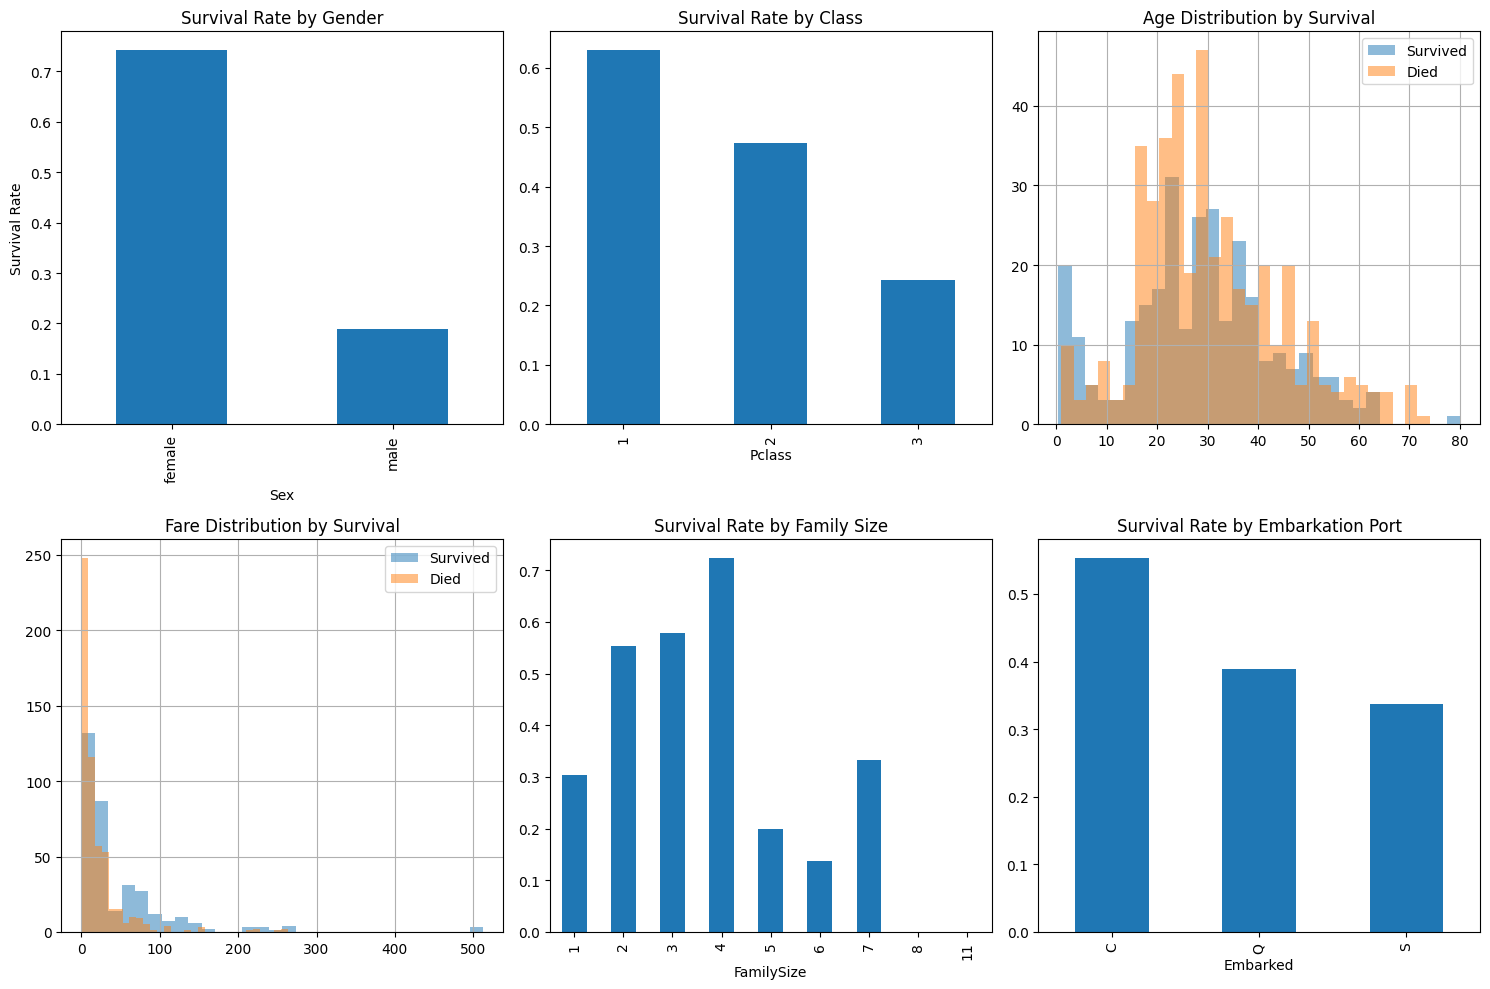

In [10]:
# Basic survival statistics
print("Survival Rate:", train['Survived'].mean())
print("\nSurvival by Gender:")
print(train.groupby('Sex')['Survived'].mean())
print("\nSurvival by Class:")
print(train.groupby('Pclass')['Survived'].mean())

# Visualize key relationships
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Survival by Sex
train.groupby('Sex')['Survived'].mean().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Survival Rate by Gender')
axes[0,0].set_ylabel('Survival Rate')

# Survival by Class
train.groupby('Pclass')['Survived'].mean().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Survival Rate by Class')

# Age distribution
train[train['Survived']==1]['Age'].hist(bins=30, ax=axes[0,2], alpha=0.5, label='Survived')
train[train['Survived']==0]['Age'].hist(bins=30, ax=axes[0,2], alpha=0.5, label='Died')
axes[0,2].set_title('Age Distribution by Survival')
axes[0,2].legend()

# Fare distribution
train[train['Survived']==1]['Fare'].hist(bins=30, ax=axes[1,0], alpha=0.5, label='Survived')
train[train['Survived']==0]['Fare'].hist(bins=30, ax=axes[1,0], alpha=0.5, label='Died')
axes[1,0].set_title('Fare Distribution by Survival')
axes[1,0].legend()

# Family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train.groupby('FamilySize')['Survived'].mean().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Survival Rate by Family Size')

# Embarked
train.groupby('Embarked')['Survived'].mean().plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Survival Rate by Embarkation Port')

plt.tight_layout()
plt.show()

In [11]:
def engineer_features(df):
    """
    Create advanced features from raw data
    Focus on Name, Cabin, and Ticket features
    """
    df = df.copy()
    
    # ===== NAME FEATURES =====
    # Extract Title from Name (Mr, Mrs, Miss, Master, etc.)
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Mme': 'Mrs', 'Don': 'Rare', 'Dona': 'Rare',
        'Lady': 'Rare', 'Countess': 'Rare', 'Jonkheer': 'Rare', 
        'Sir': 'Rare', 'Capt': 'Rare', 'Ms': 'Miss'
    }
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'].fillna('Rare', inplace=True)
    
    # Name length (can indicate social status)
    df['Name_Length'] = df['Name'].str.len()
    
    # Extract surname for family groups
    df['Surname'] = df['Name'].str.split(',').str[0]
    
    # ===== CABIN FEATURES =====
    # Cabin deck (first letter - indicates location on ship)
    df['Cabin_Deck'] = df['Cabin'].str[0]
    df['Cabin_Deck'].fillna('Unknown', inplace=True)
    
    # Has cabin information (indicates wealth/status)
    df['Has_Cabin'] = df['Cabin'].notna().astype(int)
    
    # Number of cabins (some passengers had multiple)
    df['Cabin_Count'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split()))
    
    # ===== TICKET FEATURES =====
    # Ticket prefix (often indicates ticket type/group)
    df['Ticket_Prefix'] = df['Ticket'].str.split().str[0]
    df['Ticket_Prefix'] = df['Ticket_Prefix'].apply(
        lambda x: 'Numeric' if x.isdigit() else x
    )
    
    # Ticket length
    df['Ticket_Length'] = df['Ticket'].str.len()
    
    # Shared ticket (group bookings)
    ticket_counts = df['Ticket'].value_counts()
    df['Ticket_Frequency'] = df['Ticket'].map(ticket_counts)
    df['Is_Shared_Ticket'] = (df['Ticket_Frequency'] > 1).astype(int)
    
    # ===== FAMILY FEATURES =====
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Family survival (for train set with same surname)
    # This helps identify family groups
    df['Family_Group'] = df['Surname'] + '_' + df['Ticket']
    
    # Small, Medium, Large family
    df['Family_Category'] = pd.cut(df['FamilySize'], 
                                     bins=[0, 1, 4, 20], 
                                     labels=['Alone', 'Small', 'Large'])
    
    # ===== AGE FEATURES =====
    # Age groups
    df['Age_Group'] = pd.cut(df['Age'], 
                              bins=[0, 12, 18, 35, 60, 100], 
                              labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # Is child
    df['Is_Child'] = (df['Age'] < 18).astype(int)
    
    # ===== FARE FEATURES =====
    # Fare per person (important for families)
    df['Fare_Per_Person'] = df['Fare'] / df['FamilySize']
    
    # Fare categories
    df['Fare_Category'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Med', 'High', 'VHigh'], 
                                    duplicates='drop')
    
    # ===== INTERACTION FEATURES =====
    df['Sex_Pclass'] = df['Sex'] + '_' + df['Pclass'].astype(str)
    df['Title_Pclass'] = df['Title'] + '_' + df['Pclass'].astype(str)
    
    # Women and children first
    df['Woman_or_Child'] = ((df['Sex'] == 'female') | (df['Age'] < 18)).astype(int)
    
    # Rich woman
    df['Rich_Woman'] = ((df['Sex'] == 'female') & (df['Pclass'] == 1)).astype(int)
    
    return df

# Apply feature engineering
train_fe = engineer_features(train)
test_fe = engineer_features(test)

print("New features created!")
print(f"Train shape after feature engineering: {train_fe.shape}")
print("\nNew columns:")
new_cols = [col for col in train_fe.columns if col not in train.columns]
print(new_cols)

New features created!
Train shape after feature engineering: (891, 34)

New columns:
['Title', 'Name_Length', 'Surname', 'Cabin_Deck', 'Has_Cabin', 'Cabin_Count', 'Ticket_Prefix', 'Ticket_Length', 'Ticket_Frequency', 'Is_Shared_Ticket', 'IsAlone', 'Family_Group', 'Family_Category', 'Age_Group', 'Is_Child', 'Fare_Per_Person', 'Fare_Category', 'Sex_Pclass', 'Title_Pclass', 'Woman_or_Child', 'Rich_Woman']


In [12]:
def handle_missing_values(df):
    """
    Impute missing values using smart strategies
    """
    df = df.copy()
    
    # Age: fill by Title and Pclass median
    df['Age'] = df.groupby(['Title', 'Pclass'])['Age'].transform(
        lambda x: x.fillna(x.median())
    )
    # If still missing, use overall median
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    # Embarked: fill with mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # Fare: fill with median of Pclass
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(
        lambda x: x.fillna(x.median())
    )
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Recalculate Fare_Per_Person after Fare imputation
    df['Fare_Per_Person'] = df['Fare'] / df['FamilySize']
    
    # Fill Age_Group after Age imputation
    df['Age_Group'] = pd.cut(df['Age'], 
                              bins=[0, 12, 18, 35, 60, 100], 
                              labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # Fill Is_Child
    df['Is_Child'] = (df['Age'] < 18).astype(int)
    
    # Fill Fare_Category
    df['Fare_Category'] = pd.qcut(df['Fare'], q=4, 
                                    labels=['Low', 'Med', 'High', 'VHigh'], 
                                    duplicates='drop')
    
    return df

# Handle missing values
train_fe = handle_missing_values(train_fe)
test_fe = handle_missing_values(test_fe)

print("Missing values handled!")
print("\nRemaining missing values in train:")
print(train_fe.isnull().sum()[train_fe.isnull().sum() > 0])
print("\nRemaining missing values in test:")
print(test_fe.isnull().sum()[test_fe.isnull().sum() > 0])

Missing values handled!

Remaining missing values in train:
Cabin    687
dtype: int64

Remaining missing values in test:
Cabin    327
dtype: int64


In [13]:
def encode_features(train_df, test_df, target_col='Survived'):
    """
    Encode categorical variables
    """
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    
    # Columns to drop
    drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Surname', 
                 'Family_Group', target_col]
    
    # Separate features and target
    if target_col in train_encoded.columns:
        y = train_encoded[target_col]
        train_encoded = train_encoded.drop(columns=[col for col in drop_cols if col in train_encoded.columns])
    else:
        y = None
        drop_cols.remove(target_col)
        train_encoded = train_encoded.drop(columns=[col for col in drop_cols if col in train_encoded.columns])
    
    test_encoded = test_encoded.drop(columns=[col for col in drop_cols if col in test_encoded.columns])
    
    # Identify categorical columns
    cat_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Categorical columns: {cat_cols}")
    
    # One-hot encode categorical variables
    train_encoded = pd.get_dummies(train_encoded, columns=cat_cols, drop_first=False)
    test_encoded = pd.get_dummies(test_encoded, columns=cat_cols, drop_first=False)
    
    # Align train and test columns
    train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)
    
    return train_encoded, test_encoded, y, cat_cols

# Encode features
X_train, X_test, y_train, categorical_features = encode_features(train_fe, test_fe)

print(f"\nFinal training set shape: {X_train.shape}")
print(f"Final test set shape: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")

Categorical columns: ['Sex', 'Embarked', 'Title', 'Cabin_Deck', 'Ticket_Prefix', 'Family_Category', 'Age_Group', 'Fare_Category', 'Sex_Pclass', 'Title_Pclass']

Final training set shape: (891, 112)
Final test set shape: (418, 112)
Number of features: 112


In [14]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=500,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        eval_metric='logloss'
    ),
    'CatBoost': CatBoostClassifier(
        iterations=500,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=3,
        random_state=42,
        verbose=False
    )
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate models
results = {}
trained_models = {}

print("Training models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Store results
    results[name] = {
        'mean_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std(),
        'cv_scores': cv_scores
    }
    trained_models[name] = model
    
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"Individual fold scores: {cv_scores}")
    print()

# Display results sorted by performance
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Mean CV Score': [results[m]['mean_cv_score'] for m in results.keys()],
    'Std Dev': [results[m]['std_cv_score'] for m in results.keys()]
})
results_df = results_df.sort_values('Mean CV Score', ascending=False)

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_score = results_df.iloc[0]['Mean CV Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"📊 Cross-Validation Score: {best_score:.4f}")

Training models...

Training Logistic Regression...
Logistic Regression: 0.8260 (+/- 0.0212)
Individual fold scores: [0.8547486  0.83707865 0.79213483 0.81460674 0.83146067]

Training Random Forest...
Random Forest: 0.8305 (+/- 0.0141)
Individual fold scores: [0.84357542 0.81460674 0.81460674 0.83146067 0.84831461]

Training Gradient Boosting...
Gradient Boosting: 0.8282 (+/- 0.0232)
Individual fold scores: [0.87150838 0.8258427  0.81460674 0.80337079 0.8258427 ]

Training XGBoost...
XGBoost: 0.8271 (+/- 0.0257)
Individual fold scores: [0.87709497 0.8258427  0.80898876 0.81460674 0.80898876]

Training CatBoost...
CatBoost: 0.8383 (+/- 0.0192)
Individual fold scores: [0.87150838 0.84831461 0.8258427  0.82022472 0.8258427 ]


MODEL PERFORMANCE SUMMARY
              Model  Mean CV Score  Std Dev
           CatBoost       0.838347 0.019184
      Random Forest       0.830513 0.014103
  Gradient Boosting       0.828234 0.023186
            XGBoost       0.827104 0.025742
Logistic Regression 


Top 20 Most Important Features:
              Feature  Importance
                  Age   10.864299
             Title_Mr    9.870223
          Name_Length    9.621446
                 Fare    6.379253
      Fare_Per_Person    5.892252
             Sex_male    4.996453
        Ticket_Length    4.787980
               Pclass    3.676780
     Ticket_Frequency    3.031571
           Sex_female    2.738718
           Embarked_S    2.512934
       Woman_or_Child    2.260766
Family_Category_Large    1.820949
            Has_Cabin    1.752994
  Sex_Pclass_female_2    1.553960
    Fare_Category_Med    1.271052
           FamilySize    1.265597
Family_Category_Small    1.149954
          Cabin_Count    1.120775
           Rich_Woman    1.105331


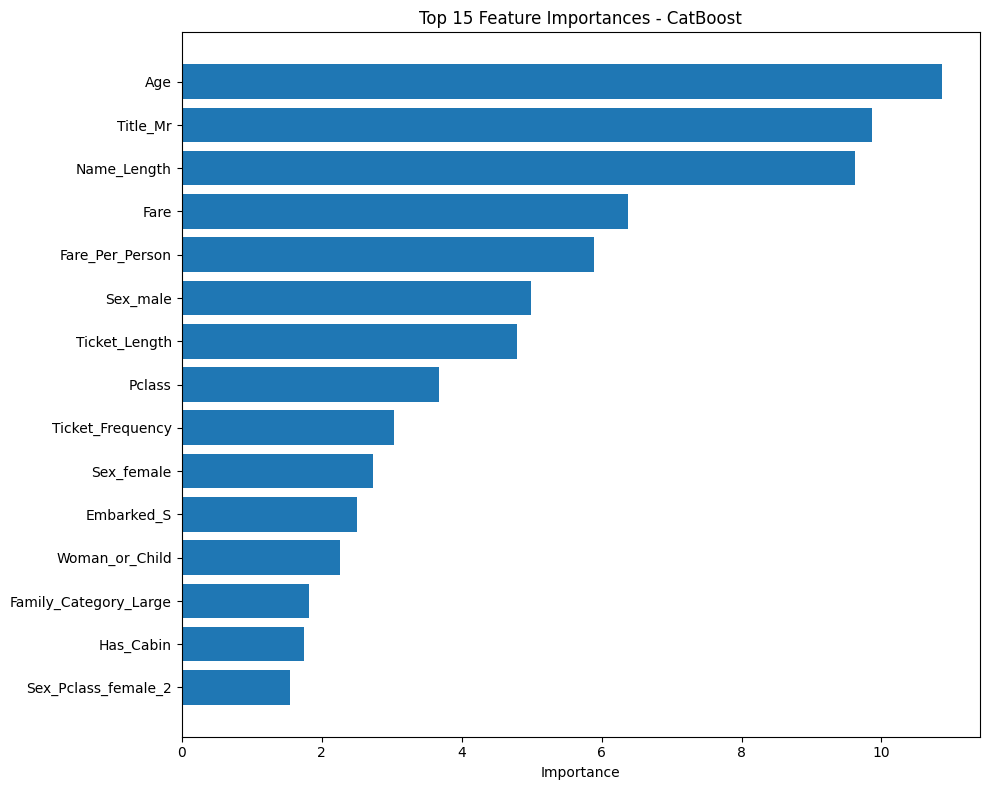

In [15]:
# Get feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20).to_string(index=False))
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model type")

In [16]:
# Create weighted ensemble of top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

print("Creating ensemble from top 3 models:")
print(top_3_models)

# Generate predictions from each model
ensemble_predictions = []
ensemble_weights = []

for model_name in top_3_models:
    model = trained_models[model_name]
    pred_proba = model.predict_proba(X_test)[:, 1]
    ensemble_predictions.append(pred_proba)
    
    # Weight by CV score
    weight = results[model_name]['mean_cv_score']
    ensemble_weights.append(weight)
    print(f"{model_name}: weight = {weight:.4f}")

# Normalize weights
ensemble_weights = np.array(ensemble_weights) / sum(ensemble_weights)

# Weighted average
ensemble_proba = np.average(ensemble_predictions, axis=0, weights=ensemble_weights)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

print(f"\nEnsemble weights: {ensemble_weights}")
print(f"Ensemble predictions shape: {ensemble_pred.shape}")

Creating ensemble from top 3 models:
['CatBoost', 'Random Forest', 'Gradient Boosting']
CatBoost: weight = 0.8383
Random Forest: weight = 0.8305
Gradient Boosting: weight = 0.8282

Ensemble weights: [0.33572894 0.33259178 0.33167929]
Ensemble predictions shape: (418,)


In [17]:
# Use best single model predictions (or ensemble if you prefer)
final_predictions = best_model.predict(X_test)

# Alternative: Use ensemble predictions
# final_predictions = ensemble_pred

# Create submission dataframe
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Survived': final_predictions
})

# Save to CSV
submission.to_csv('titanic_submission.csv', index=False)

print("\n" + "="*60)
print("SUBMISSION FILE CREATED!")
print("="*60)
print(f"File: titanic_submission.csv")
print(f"Shape: {submission.shape}")
print(f"Survival rate in predictions: {submission['Survived'].mean():.2%}")
print("\nFirst 10 predictions:")
print(submission.head(10))
print("\nLast 10 predictions:")
print(submission.tail(10))
print("="*60)

# Display submission statistics
print("\n📊 SUBMISSION STATISTICS:")
print(f"Total passengers: {len(submission)}")
print(f"Predicted survivors: {submission['Survived'].sum()}")
print(f"Predicted deaths: {(1-submission['Survived']).sum()}")
print(f"Survival rate: {submission['Survived'].mean():.2%}")

print("\n✅ Ready to submit to Kaggle!")
print("Upload 'titanic_submission.csv' to the competition page.")


SUBMISSION FILE CREATED!
File: titanic_submission.csv
Shape: (418, 2)
Survival rate in predictions: 36.60%

First 10 predictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         0
7          899         0
8          900         1
9          901         0

Last 10 predictions:
     PassengerId  Survived
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         0
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

📊 SUBMISSION STATISTICS:
Total passengers: 418
Predicted survivors: 153
Predicted deaths: 265
Survival rate: 36.60%

✅ Ready to submit to Kaggle!
Upload 'titanic_submission.csv' to the competition page.
